## 数据库连接,初始化

In [ ]:
# ===== 共用配置与函数库 =====
import os
import sys
import pymysql
from datetime import datetime, timezone
import requests
import pandas as pd

# 导入 config 配置
sys.path.append(os.getcwd())
try:
    import config
    print("✅ 成功导入 config.py")
except ImportError:
    print("❌ 导入 config.py 失败，请确保文件存在")

# 数据库连接函数（共用）
def get_db_connection():
    """创建数据库连接"""
    try:
        conn = pymysql.connect(
            host=config.DB_HOST,
            user=config.DB_USER,
            password=config.DB_PASSWORD,
            database=config.DB_NAME,
            charset='utf8mb4'
        )
        return conn
    except pymysql.Error as e:
        print(f"数据库连接失败: {e}")
        return None

print("✅ 共用函数库加载完成（包含 get_db_connection()）")

## Json collected data by API and save to MySQL database, with error handling and logging


In [ ]:
import os
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
import sys

# 将当前目录添加到路径以便导入 config
sys.path.append(os.getcwd())
try:
    import config
    print("✅ 成功导入 config.py")
except ImportError:
    print("❌ 导入 config.py 失败，请确保文件存在")

# --- 2. 建立连接 ---
engine = create_engine(f"mysql+pymysql://{config.DB_USER}:{config.DB_PASSWORD}@{config.DB_HOST}:3306/{config.DB_NAME}")

# --- 3. 批量读取与合并 ---
all_files = [f for f in os.listdir(config.FOLDER_PATH) if f.endswith('.json')]
data_list = []

print(f"发现 {len(all_files)} 个 JSON 文件，开始读取...")

for filename in all_files:
    file_path = os.path.join(config.FOLDER_PATH, filename)
    try:
        # 读取 JSON
        df = pd.read_json(file_path)
        
        # 处理 snapshot_time timestamp转换
        snapshot_str = filename.split('_')[2].split('.')[0]
        snapshot_datetime = datetime.strptime(snapshot_str, '%Y%m%dT%H%M%SZ')
        df['snapshot_time'] = snapshot_datetime
        
        # 处理 position 列
        if 'position' in df.columns and df['position'].dtype == 'object':
            df['lat'] = df['position'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)
            df['lng'] = df['position'].apply(lambda x: x.get('lng') if isinstance(x, dict) else None)
            df = df.drop('position', axis=1)
        
        # 删除无效列
        df = df.drop(['banking', 'bonus'], axis=1, errors='ignore')
        
        data_list.append(df)
    except Exception as e:
        print(f"读取失败 {filename}: {e}")

if data_list:
    final_df = pd.concat(data_list, ignore_index=True)
    print(f"✅ 数据读取完成，共 {len(final_df)} 行")
else:
    print("❌ 未发现有效 JSON 文件")

## Json 数据清洗保存到 MySQL 数据库，包含错误处理和日志记录

In [ ]:
# --- 4.5. 填补 available_bike_stands 缺失值 ---
print("=== 填补缺失数据开始 ===")
if 'available_bike_stands' in final_df.columns:
    na_count = final_df['available_bike_stands'].isna().sum()
    if 'bike_stands' in final_df.columns and 'available_bikes' in final_df.columns:
        mask = final_df['available_bike_stands'].isna()
        final_df.loc[mask, 'available_bike_stands'] = (
            final_df.loc[mask, 'bike_stands'] - final_df.loc[mask, 'available_bikes']
        )
        print(f"✅ 填补了 {na_count} 条数据")

# --- 5. 数据类型转换与拆分 ---
# 转换为 DATETIME
if 'last_update' in final_df.columns:
    final_df['last_update'] = pd.to_datetime(final_df['last_update'], unit='ms')
if 'snapshot_time' in final_df.columns:
    final_df['snapshot_time'] = pd.to_datetime(final_df['snapshot_time'])

# 拆分为静态表 (stations) - 严格去重
stations_df = final_df[['number', 'contract_name', 'name', 'address', 'lat', 'lng']].drop_duplicates(subset=['number'])

# 拆分为动态表 (availability) - 确保包含所有需要的列
availability_df = final_df[['number', 'bike_stands', 'available_bike_stands', 'available_bikes', 'status', 'last_update', 'snapshot_time']].copy()

# --- 6. 写入数据库 ---
print(f"\n=== 写入数据库 (拆分表结构) ===")

from sqlalchemy import text

with engine.begin() as conn:
    # 1. 清理旧表
    try:
        conn.execute(text("DROP TABLE IF EXISTS stations"))
        conn.execute(text("DROP TABLE IF EXISTS availability"))
    except:
        pass
    
    # 2. 写入静态信息（重新创建表，确保主键）
    stations_df.to_sql('stations', con=conn, if_exists='replace', index=False)
    conn.execute(text("ALTER TABLE stations MODIFY COLUMN number BIGINT PRIMARY KEY;"))
    print(f"✅ 'stations' 表创建成功 ({len(stations_df)} 个站点)，已设置 number 为主键")

    # 3. 写入动态信息（确保所有列包括 snapshot_time）
    availability_df.to_sql('availability', con=conn, if_exists='replace', index=False)
    print(f"✅ 'availability' 表创建成功 ({len(availability_df)} 条记录)")
    
    # 验证表结构
    print("\n=== 表结构验证 ===")
    cursor = conn.connection.cursor()
    cursor.execute("DESCRIBE availability")
    print("availability 表列定义:")
    for col_info in cursor.fetchall():
        print(f"  {col_info[0]}: {col_info[1]}")

print("\n=== 最终数据预览 ===")
print(f"Stations (共 {len(stations_df)} 个):")
display(stations_df.head(2))
print(f"\nAvailability (共 {len(availability_df)} 行):")
display(availability_df.head(2))

## 读取数据库内容

In [50]:
# 检查表结构（单独执行，使用共用的 get_db_connection()）
def check_table_structure():
    conn = get_db_connection()
    if conn is None: return None
    try:
        cursor = conn.cursor()
        print("--- Stations 表结构 ---")
        cursor.execute("DESCRIBE stations")
        for col in cursor.fetchall(): print(f"  {col[0]}: {col[1]}")
        print("\n--- Availability 表结构 ---")
        cursor.execute("DESCRIBE availability")
        cols = cursor.fetchall()
        for col in cols: print(f"  {col[0]}: {col[1]}")
        

            
    except pymysql.Error as e:
        print(f"查询失败: {e}")
    finally:
        cursor.close()
        conn.close()


print("=== 读取数据库表结构 ===\n")
check_table_structure()


=== 读取数据库表结构 ===

--- Stations 表结构 ---
  number: bigint
  contract_name: text
  name: text
  address: text
  lat: double
  lng: double

--- Availability 表结构 ---
  number: bigint
  bike_stands: bigint
  available_bike_stands: bigint
  available_bikes: bigint
  status: text
  last_update: datetime
  snapshot_time: datetime


In [ ]:
# 从 API 抓取并更新数据库（单独执行，使用共用的 get_db_connection()）

def fetch_and_save_to_db():
    conn = get_db_connection()
    if conn is None: return False
    
    try:
        print("正在从 API 抓取数据...")
        resp = requests.get(config.BIKE_STATUS_URL, timeout=20)
        resp.raise_for_status()
        data = resp.json()
        print(f"✅ 成功获取 {len(data)} 个站点的数据\n")
        
        cursor = conn.cursor()
        inserted_count = 0
        
        for station in data:
            try:
                # 1. 静态信息 (stations)
                position = station.get('position', {})
                insert_station_sql = """
                INSERT IGNORE INTO stations (number, contract_name, name, address, lat, lng)
                VALUES (%s, %s, %s, %s, %s, %s)
                """
                cursor.execute(insert_station_sql, (
                    station.get('number'),
                    station.get('contract_name'),
                    station.get('name'),
                    station.get('address'),
                    position.get('lat'),
                    position.get('lng')
                ))

                # 2. 动态信息 (availability) timestamp 转换
                last_update_ms = station.get('last_update', 0)
                last_update = datetime.fromtimestamp(last_update_ms / 1000, tz=timezone.utc)
                snapshot_time = datetime.now(timezone.utc)
                
                # 自动补全 logic
                bike_stands = station.get('bike_stands', 0)
                available_bikes = station.get('available_bikes', 0)
                available_bike_stands = station.get('available_bike_stands')
                if available_bike_stands is None:
                    available_bike_stands = bike_stands - available_bikes

                insert_avail_sql = """
                INSERT INTO availability 
                (number, bike_stands, available_bike_stands, available_bikes, status, last_update, snapshot_time)
                VALUES (%s, %s, %s, %s, %s, %s, %s)
                """
                
                values = (
                    station.get('number'),
                    bike_stands,
                    available_bike_stands,
                    available_bikes,
                    station.get('status'),
                    last_update,
                    snapshot_time
                )
                
                cursor.execute(insert_avail_sql, values)
                inserted_count += 1
                
            except Exception as e:
                print(f"⚠️  处理站点 {station.get('number')} 失败: {e}")
                continue
        
        conn.commit()
        print(f"✅ 成功插入 {inserted_count} 条实时动态数据到数据库")
        return True
    except Exception as e:
        print(f"❌ 运行失败: {e}")
        return False
    finally:
        cursor.close()
        conn.close()
print("抓取数据中")
result = fetch_and_save_to_db()  # ✅ 添加括号执行函数
if result:
    print("\n✅ 数据更新完成，请运行 Cell 10 查看最新统计")
else:
    print("\n❌ 数据更新失败，请检查 API 连接")

抓取数据中
正在从 API 抓取数据...
✅ 成功获取 114 个站点的数据

✅ 成功插入 114 条实时动态数据到数据库

✅ 数据更新完成，请运行 Cell 10 查看最新统计


In [53]:
# 数据库查询（使用共用的 get_db_connection() 函数）
conn = get_db_connection()

if conn is not None:
    try:
        # 1. 查询静态站点总数
        stations_df = pd.read_sql("SELECT * FROM stations", conn)
        print(f"🏢 站点总数 (stations): {len(stations_df)}")
        
        # 2. 查询动态记录总数 - 从数据库读取最新的 availability
        avail_df = pd.read_sql("SELECT * FROM availability", conn)
        print(f"📊 动态记录总数 (availability): {len(avail_df)}")
        
        # 3. 联表查询示例 (演示如何把拆分的表合回来)
        query = """
        SELECT s.name, a.available_bikes, a.available_bike_stands, a.snapshot_time 
        FROM stations s
        JOIN availability a ON s.number = a.number
        ORDER BY a.snapshot_time DESC
        LIMIT 10
        """
        merged_df = pd.read_sql(query, conn)
        print("\n📈 最新 10 条联表记录:")
        display(merged_df)
        
        # 检查缺失值（使用数据库中的最新数据）
        print("\n❓ Availability 缺失值统计:")
        display(avail_df.isna().sum())
        
        print("\n📋 最后 5 行数据（数据库中的最新数据）:")
        display(avail_df.tail())
        
        # ✨ 新增：显示时间范围统计
        print("\n📅 数据时间范围统计:")
        time_stats = pd.read_sql("""
        SELECT 
            DATE(snapshot_time) AS date,
            COUNT(*) AS record_count,
            COUNT(DISTINCT number) AS unique_stations
        FROM availability
        GROUP BY DATE(snapshot_time)
        ORDER BY date DESC
        """, conn)
        display(time_stats)
        
    finally:
        conn.close()
        print("\n✅ 数据库连接已关闭")
else:
    print("❌ 无法连接数据库")

/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/3747923724.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stations_df = pd.read_sql("SELECT * FROM stations", conn)
/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/3747923724.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  avail_df = pd.read_sql("SELECT * FROM availability", conn)


🏢 站点总数 (stations): 114
📊 动态记录总数 (availability): 66804

📈 最新 10 条联表记录:


/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/3747923724.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  merged_df = pd.read_sql(query, conn)


,name,available_bikes,available_bike_stands,snapshot_time
0,SMITHFIELD NORTH,9,21,2026-02-09 17:49:53
1,PARNELL SQUARE NORTH,2,18,2026-02-09 17:49:53
2,CLONMEL STREET,0,33,2026-02-09 17:49:53
3,AVONDALE ROAD,13,22,2026-02-09 17:49:53
4,JAMES STREET EAST,0,30,2026-02-09 17:49:53
5,MOUNT STREET LOWER,11,29,2026-02-09 17:49:53
6,CHRISTCHURCH PLACE,1,19,2026-02-09 17:49:53
7,GRANTHAM STREET,2,28,2026-02-09 17:49:53
8,PEARSE STREET,13,17,2026-02-09 17:49:53
9,YORK STREET EAST,7,25,2026-02-09 17:49:53



❓ Availability 缺失值统计:


number                   0
bike_stands              0
available_bike_stands    0
available_bikes          0
status                   0
last_update              0
snapshot_time            0
dtype: int64


📋 最后 5 行数据（数据库中的最新数据）:


,number,bike_stands,available_bike_stands,available_bikes,status,last_update,snapshot_time
66799,39,20,10,10,OPEN,2026-02-09 17:49:33,2026-02-09 17:49:53
66800,83,40,27,13,OPEN,2026-02-09 17:45:12,2026-02-09 17:49:53
66801,92,40,7,33,OPEN,2026-02-09 17:45:48,2026-02-09 17:49:53
66802,21,30,29,1,OPEN,2026-02-09 17:45:36,2026-02-09 17:49:53
66803,88,30,27,3,OPEN,2026-02-09 17:48:46,2026-02-09 17:49:53



📅 数据时间范围统计:


/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/3747923724.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_stats = pd.read_sql("""


,date,record_count,unique_stations
0,2026-02-09,684,114
1,2026-02-05,16530,114
2,2026-02-04,32604,114
3,2026-02-03,16986,114



✅ 数据库连接已关闭


In [1]:
# ceil 11 优化数据库查询和分析（使用 SQLAlchemy 和 Pandas，无警告）

from sqlalchemy import create_engine
import pandas as pd
import sys
import os

sys.path.append(os.getcwd())
import config

print("=" * 60)
print("📊 数据库查询与统计分析")
print("=" * 60)

# 使用 SQLAlchemy 引擎（与 Pandas 无缝集成，无警告）
try:
    engine = create_engine(
        f"mysql+pymysql://{config.DB_USER}:{config.DB_PASSWORD}@{config.DB_HOST}:3306/{config.DB_NAME}",
        echo=False
    )
    
    # ===== 1️⃣ 基础数据统计 =====
    print("\n📈 基础数据统计")
    print("-" * 60)
    
    summary_query = """
    SELECT 
        (SELECT COUNT(*) FROM stations) as total_stations,
        (SELECT COUNT(*) FROM availability) as total_records,
        (SELECT COUNT(DISTINCT DATE(snapshot_time)) FROM availability) as total_days,
        (SELECT MAX(snapshot_time) FROM availability) as latest_update,
        (SELECT MIN(snapshot_time) FROM availability) as earliest_update
    """
    summary_df = pd.read_sql(summary_query, engine)
    
    print(f"🏢 站点总数: {int(summary_df['total_stations'][0])}")
    print(f"📊 记录总数: {int(summary_df['total_records'][0])}")
    print(f"📅 覆盖天数: {int(summary_df['total_days'][0])}")
    print(f"🕐 最新更新: {summary_df['latest_update'][0]}")
    print(f"🕐 最早数据: {summary_df['earliest_update'][0]}")
    
    # ===== 2️⃣ 站点信息 =====
    print("\n🏪 站点信息")
    print("-" * 60)
    
    stations_df = pd.read_sql(
        "SELECT number, name, address, lat, lng FROM stations ORDER BY number LIMIT 10",
        engine
    )
    print(f"✅ 已加载 {len(stations_df)} 个站点（显示前10个）")
    display(stations_df)
    
    # ===== 3️⃣ 可用性数据统计 =====
    print("\n📍 可用性数据统计")
    print("-" * 60)
    
    availability_stats = pd.read_sql("""
    SELECT 
        COUNT(*) as total_records,
        COUNT(DISTINCT number) as unique_stations,
        ROUND(AVG(available_bikes), 2) as avg_available_bikes,
        MAX(available_bikes) as max_bikes,
        MIN(available_bikes) as min_bikes,
        ROUND(AVG(available_bike_stands), 2) as avg_available_stands,
        MAX(available_bike_stands) as max_stands,
        MIN(available_bike_stands) as min_stands
    FROM availability
    """, engine)
    
    print(f"📊 总记录数: {int(availability_stats['total_records'][0])}")
    print(f"🏤 独立站点数: {int(availability_stats['unique_stations'][0])}")
    print(f"🚴 平均可用自行车: {availability_stats['avg_available_bikes'][0]}")
    print(f"   最大: {int(availability_stats['max_bikes'][0])}, 最小: {int(availability_stats['min_bikes'][0])}")
    print(f"🅿️  平均可用停泊位: {availability_stats['avg_available_stands'][0]}")
    print(f"   最大: {int(availability_stats['max_stands'][0])}, 最小: {int(availability_stats['min_stands'][0])}")
    
    # ===== 4️⃣ 时间分布统计 =====
    print("\n📅 时间分布统计")
    print("-" * 60)
    
    time_stats = pd.read_sql("""
    SELECT 
        DATE(snapshot_time) as date,
        COUNT(*) as record_count,
        COUNT(DISTINCT number) as unique_stations,
        ROUND(AVG(available_bikes), 2) as avg_bikes,
        MAX(snapshot_time) as latest_time
    FROM availability
    GROUP BY DATE(snapshot_time)
    ORDER BY date DESC
    LIMIT 10
    """, engine)
    
    print(f"✅ 显示最近 {len(time_stats)} 天的统计数据：")
    display(time_stats)
    
    # ===== 5️⃣ 最新数据快照 =====
    print("\n⚡ 最新数据快照（TOP 10）")
    print("-" * 60)
    
    latest_data = pd.read_sql("""
    SELECT 
        s.number,
        s.name,
        a.available_bikes,
        a.available_bike_stands,
        a.bike_stands,
        a.status,
        a.snapshot_time
    FROM availability a
    JOIN stations s ON a.number = s.number
    WHERE a.snapshot_time = (SELECT MAX(snapshot_time) FROM availability)
    ORDER BY s.number
    LIMIT 10
    """, engine)
    
    if not latest_data.empty:
        print(f"✅ 最新快照时间: {latest_data['snapshot_time'].iloc[0]}")
        display(latest_data)
    else:
        print("⚠️ 没有最新数据")
    
    # ===== 6️⃣ 站点高峰分析 =====
    print("\n🔝 可用性排行（按平均可用自行车数）")
    print("-" * 60)
    
    top_stations = pd.read_sql("""
    SELECT 
        s.number,
        s.name,
        COUNT(a.number) as records,
        ROUND(AVG(a.available_bikes), 2) as avg_bikes,
        ROUND(AVG(a.available_bike_stands), 2) as avg_stands,
        MAX(a.available_bikes) as max_bikes
    FROM availability a
    JOIN stations s ON a.number = s.number
    GROUP BY a.number, s.name
    ORDER BY avg_bikes DESC
    LIMIT 10
    """, engine)
    
    if not top_stations.empty:
        display(top_stations)
    else:
        print("⚠️ 没有数据")
    
    # ===== 7️⃣ 数据质量检查 =====
    print("\n✔️ 数据质量检查")
    print("-" * 60)
    
    quality_stats = pd.read_sql("""
    SELECT 
        COUNT(*) as total_records,
        SUM(CASE WHEN available_bikes IS NULL THEN 1 ELSE 0 END) as null_bikes_count,
        SUM(CASE WHEN available_bike_stands IS NULL THEN 1 ELSE 0 END) as null_stands_count,
        SUM(CASE WHEN status IS NULL THEN 1 ELSE 0 END) as null_status_count,
        SUM(CASE WHEN available_bikes < 0 THEN 1 ELSE 0 END) as negative_bikes_count,
        SUM(CASE WHEN available_bike_stands < 0 THEN 1 ELSE 0 END) as negative_stands_count
    FROM availability
    """, engine)
    
    total = int(quality_stats['total_records'][0])
    null_bikes = int(quality_stats['null_bikes_count'][0])
    null_stands = int(quality_stats['null_stands_count'][0])
    null_status = int(quality_stats['null_status_count'][0])
    neg_bikes = int(quality_stats['negative_bikes_count'][0])
    neg_stands = int(quality_stats['negative_stands_count'][0])
    
    print(f"📊 总记录数: {total}")
    print(f"✅ available_bikes 缺失: {null_bikes} ({100*null_bikes/total if total > 0 else 0:.2f}%)")
    print(f"✅ available_bike_stands 缺失: {null_stands} ({100*null_stands/total if total > 0 else 0:.2f}%)")
    print(f"✅ status 缺失: {null_status} ({100*null_status/total if total > 0 else 0:.2f}%)")
    print(f"⚠️  负数 available_bikes: {neg_bikes}")
    print(f"⚠️  负数 available_bike_stands: {neg_stands}")
    
    # ===== 8️⃣ 小时分布 =====
    print("\n⏰ 每小时平均数据分布")
    print("-" * 60)
    
    hourly_stats = pd.read_sql("""
    SELECT 
        HOUR(snapshot_time) as hour,
        COUNT(*) as record_count,
        ROUND(AVG(available_bikes), 2) as avg_bikes,
        ROUND(AVG(available_bike_stands), 2) as avg_stands
    FROM availability
    GROUP BY HOUR(snapshot_time)
    ORDER BY hour ASC
    """, engine)
    
    if not hourly_stats.empty:
        print(f"✅ 共 {len(hourly_stats)} 个小时时段：")
        display(hourly_stats)
    else:
        print("⚠️ 没有数据")
    
    # ===== 资源清理 =====
    engine.dispose()
    print("\n" + "=" * 60)
    print("✅ 数据库查询完成，连接已关闭")
    print("=" * 60)
    
except Exception as e:
    print(f"\n❌ 查询失败: {e}")
    import traceback
    traceback.print_exc()

📊 数据库查询与统计分析

📈 基础数据统计
------------------------------------------------------------
🏢 站点总数: 114
📊 记录总数: 66804
📅 覆盖天数: 4
🕐 最新更新: 2026-02-09 17:49:53
🕐 最早数据: 2026-02-03 11:18:48

🏪 站点信息
------------------------------------------------------------
✅ 已加载 10 个站点（显示前10个）


,number,name,address,lat,lng
0,1,CLARENDON ROW,Clarendon Row,53.340927,-6.262501
1,2,BLESSINGTON STREET,Blessington Street,53.356769,-6.268140
2,3,BOLTON STREET,Bolton Street,53.351182,-6.269859
3,4,GREEK STREET,Greek Street,53.346874,-6.272976
4,5,CHARLEMONT PLACE,Charlemont Street,53.330704,-6.260004
5,6,CHRISTCHURCH PLACE,Christchurch Place,53.343368,-6.270120
6,7,HIGH STREET,High Street,53.343420,-6.274413
7,8,CUSTOM HOUSE QUAY,Custom House Quay,53.347884,-6.248048
8,9,EXCHEQUER STREET,Exchequer Street,53.343034,-6.263578
9,10,DAME STREET,Dame Street,53.344007,-6.266802



📍 可用性数据统计
------------------------------------------------------------
📊 总记录数: 66804
🏤 独立站点数: 114
🚴 平均可用自行车: 11.66
   最大: 40, 最小: 0
🅿️  平均可用停泊位: 19.94
   最大: 40, 最小: 0

📅 时间分布统计
------------------------------------------------------------
✅ 显示最近 4 天的统计数据：


,date,record_count,unique_stations,avg_bikes,latest_time
0,2026-02-09,684,114,10.88,2026-02-09 17:49:53
1,2026-02-05,16530,114,11.77,2026-02-05 12:01:08
2,2026-02-04,32604,114,11.56,2026-02-04 23:55:48
3,2026-02-03,16986,114,11.78,2026-02-03 23:59:51



⚡ 最新数据快照（TOP 10）
------------------------------------------------------------
✅ 最新快照时间: 2026-02-09 17:49:53


,number,name,available_bikes,available_bike_stands,bike_stands,status,snapshot_time
0,1,CLARENDON ROW,27,4,31,OPEN,2026-02-09 17:49:53
1,2,BLESSINGTON STREET,1,19,20,OPEN,2026-02-09 17:49:53
2,3,BOLTON STREET,8,12,20,OPEN,2026-02-09 17:49:53
3,4,GREEK STREET,5,15,20,OPEN,2026-02-09 17:49:53
4,5,CHARLEMONT PLACE,27,13,40,OPEN,2026-02-09 17:49:53
5,6,CHRISTCHURCH PLACE,1,19,20,OPEN,2026-02-09 17:49:53
6,7,HIGH STREET,3,26,29,OPEN,2026-02-09 17:49:53
7,8,CUSTOM HOUSE QUAY,18,12,30,OPEN,2026-02-09 17:49:53
8,9,EXCHEQUER STREET,8,15,24,OPEN,2026-02-09 17:49:53
9,10,DAME STREET,9,7,16,OPEN,2026-02-09 17:49:53



🔝 可用性排行（按平均可用自行车数）
------------------------------------------------------------


,number,name,records,avg_bikes,avg_stands,max_bikes
0,38,TALBOT STREET,586,32.06,7.83,39
1,92,HEUSTON BRIDGE (NORTH),586,28.08,11.86,40
2,97,KILMAINHAM GAOL,586,27.43,12.53,40
3,5,CHARLEMONT PLACE,586,27.34,12.60,40
4,83,EMMET ROAD,586,25.41,14.54,33
5,104,GRANGEGORMAN LOWER (CENTRAL),586,24.73,15.27,31
6,80,ST JAMES HOSPITAL (LUAS),586,24.28,15.45,32
7,93,HEUSTON STATION (CENTRAL),586,24.28,15.66,40
8,73,FRANCIS STREET,586,23.59,6.41,30
9,85,ROTHE ABBEY,586,21.82,13.12,28



✔️ 数据质量检查
------------------------------------------------------------
📊 总记录数: 66804
✅ available_bikes 缺失: 0 (0.00%)
✅ available_bike_stands 缺失: 0 (0.00%)
✅ status 缺失: 0 (0.00%)
⚠️  负数 available_bikes: 0
⚠️  负数 available_bike_stands: 0

⏰ 每小时平均数据分布
------------------------------------------------------------
✅ 共 24 个小时时段：


,hour,record_count,avg_bikes,avg_stands
0,0,2736,12.15,19.49
1,1,2736,12.18,19.45
2,2,2736,12.18,19.45
3,3,2736,12.09,19.31
4,4,2736,12.18,19.44
5,5,2622,12.09,19.54
6,6,2736,11.72,19.92
7,7,2736,11.46,20.17
8,8,2622,10.54,20.89
9,9,2736,10.97,20.48



✅ 数据库查询完成，连接已关闭


📊 优化后的数据可视化分析 - 清晰的趋势展示

📊 数据范围统计：
  每小时平均自行车数范围: 10.5 ~ 12.2
  最小值全局范围: 0.0 ~ 0.0
  最大值全局范围: 38.0 ~ 40.0
  标准差范围: 7.8 ~ 10.6


/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/1738460095.py:232: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/1738460095.py:232: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/1738460095.py:232: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/1738460095.py:232: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/jw/0ttqd5gn6_zf0xv62ypjvn9r0000gn/T/ipykernel_38940/1738460095.py:232: UserWarning: Glyph 128692 (\N{BICYCLIST}) missing from font(s) Arial Unicode MS.
  plt.tight_layout()
/var/folders/jw/0ttqd5gn6_zf0


✅ 图表已保存为 'bike_availability_analysis.png'


/opt/anaconda3/envs/comp47350py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/comp47350py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/comp47350py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/comp47350py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/comp47350py312/lib/python3.12/site-packages/IPython/core/pylabt

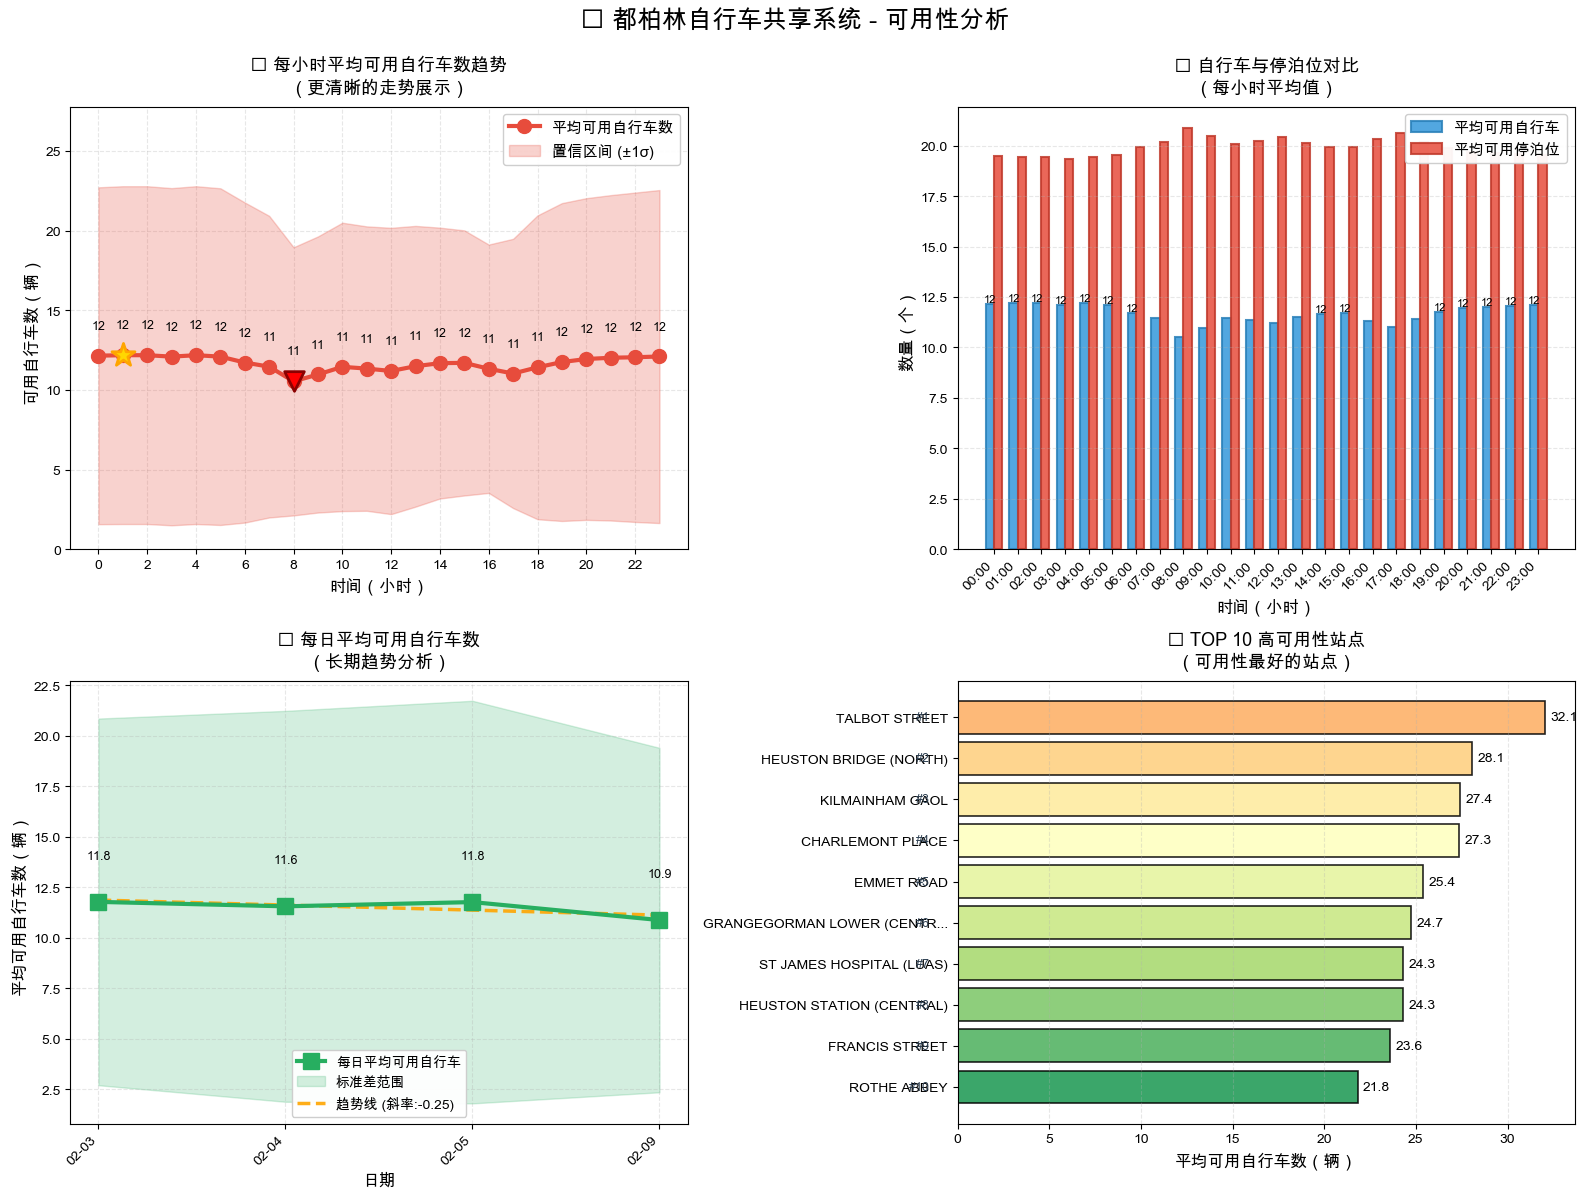


📊 可视化分析详细摘要

🕐 每小时分析：
  • 最高峰时段: 01:00 - 12.2 辆车
  • 最低谷时段: 08:00 - 10.5 辆车
  • 波动范围: 1.6 辆车
  • 24小时平均: 11.7 辆车
  • 整体标准差: 9.6 辆车

  📈 高峰期（前25%）的时段:
     00:00 - 12.2 辆
     01:00 - 12.2 辆
     02:00 - 12.2 辆
     04:00 - 12.2 辆
     23:00 - 12.1 辆

  📉 低谷期（后25%）的时段:
     08:00 - 10.5 辆
     09:00 - 11.0 辆
     11:00 - 11.3 辆
     12:00 - 11.2 辆
     16:00 - 11.3 辆
     17:00 - 11.0 辆

📅 按日期分析：
  • 数据覆盖期间: 2026-02-03 至 2026-02-09
  • 日均最高: 11.8 辆车 (2026-02-03)
  • 日均最低: 10.9 辆车 (2026-02-09)
  • 总体平均: 11.5 辆车
  • 日间波动: 0.4 辆车（标准差）
  • 长期趋势: 下降趋势 📉（每天变化 0.25 辆）

🏆 TOP 3 高可用性站点：
  1. TALBOT STREET
     平均可用: 32.1 辆 | 停泊位: 7.8 | 样本数: 586
  2. HEUSTON BRIDGE (NORTH)
     平均可用: 28.1 辆 | 停泊位: 11.9 | 样本数: 586
  3. KILMAINHAM GAOL
     平均可用: 27.4 辆 | 停泊位: 12.5 | 样本数: 586

✅ 优化后的可视化分析完成！


In [56]:
# ===== Cell 12-优化版: 数据可视化分析 =====

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import sys
import os
from datetime import datetime

sys.path.append(os.getcwd())
import config

print("=" * 70)
print("📊 优化后的数据可视化分析 - 清晰的趋势展示")
print("=" * 70)

try:
    # 创建数据库连接
    engine = create_engine(
        f"mysql+pymysql://{config.DB_USER}:{config.DB_PASSWORD}@{config.DB_HOST}:3306/{config.DB_NAME}",
        echo=False
    )
    
    # ===== 查询数据 =====
    # 1. 每小时平均可用自行车数（所有站点）
    hourly_avg_query = """
    SELECT 
        HOUR(snapshot_time) as hour,
        COUNT(*) as record_count,
        COUNT(DISTINCT number) as unique_stations,
        ROUND(AVG(available_bikes), 2) as avg_bikes,
        ROUND(MIN(available_bikes), 2) as min_bikes,
        ROUND(MAX(available_bikes), 2) as max_bikes,
        ROUND(STDDEV_POP(available_bikes), 2) as std_bikes,
        ROUND(AVG(available_bikes) - STDDEV_POP(available_bikes), 2) as lower_bound,
        ROUND(AVG(available_bikes) + STDDEV_POP(available_bikes), 2) as upper_bound,
        ROUND(AVG(available_bike_stands), 2) as avg_stands,
        ROUND(MAX(available_bike_stands), 2) as max_stands
    FROM availability
    GROUP BY HOUR(snapshot_time)
    ORDER BY hour ASC
    """
    hourly_df = pd.read_sql(hourly_avg_query, engine)
    
    # 2. 按日期的每日平均
    daily_avg_query = """
    SELECT 
        DATE(snapshot_time) as date,
        ROUND(AVG(available_bikes), 2) as avg_bikes,
        ROUND(STDDEV_POP(available_bikes), 2) as std_bikes,
        ROUND(AVG(available_bike_stands), 2) as avg_stands,
        COUNT(*) as record_count
    FROM availability
    GROUP BY DATE(snapshot_time)
    ORDER BY date ASC
    """
    daily_df = pd.read_sql(daily_avg_query, engine)
    
    # 3. 站点级别的数据（TOP 10 站点）
    top_stations_query = """
    SELECT 
        s.number,
        s.name,
        ROUND(AVG(a.available_bikes), 2) as avg_bikes,
        ROUND(AVG(a.available_bike_stands), 2) as avg_stands,
        COUNT(a.number) as records
    FROM availability a
    JOIN stations s ON a.number = s.number
    GROUP BY a.number, s.name
    ORDER BY avg_bikes DESC
    LIMIT 10
    """
    top_stations_df = pd.read_sql(top_stations_query, engine)
    
    # ===== 打印数据范围供参考 =====
    print("\n📊 数据范围统计：")
    print(f"  每小时平均自行车数范围: {hourly_df['avg_bikes'].min():.1f} ~ {hourly_df['avg_bikes'].max():.1f}")
    print(f"  最小值全局范围: {hourly_df['min_bikes'].min():.1f} ~ {hourly_df['min_bikes'].max():.1f}")
    print(f"  最大值全局范围: {hourly_df['max_bikes'].min():.1f} ~ {hourly_df['max_bikes'].max():.1f}")
    print(f"  标准差范围: {hourly_df['std_bikes'].min():.1f} ~ {hourly_df['std_bikes'].max():.1f}")
    
    # ===== 创建图表 =====
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建 2x2 的子图布局
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('🚴 都柏林自行车共享系统 - 可用性分析', fontsize=18, fontweight='bold', y=0.995)
    
    # ===== 图1：每小时平均可用自行车数（优化版 - 使用标准差）=====
    ax1 = plt.subplot(2, 2, 1)
    
    # 绘制主线
    ax1.plot(hourly_df['hour'], hourly_df['avg_bikes'], 
             marker='o', linewidth=3, markersize=10, color='#E74C3C', 
             label='平均可用自行车数', zorder=4)
    
    # 绘制置信区间（使用标准差 ±1σ）- 更合理的范围
    ax1.fill_between(hourly_df['hour'], 
                      hourly_df['lower_bound'], 
                      hourly_df['upper_bound'],
                      alpha=0.25, color='#E74C3C', 
                      label='置信区间 (±1σ)', zorder=2)
    
    # 添加网格和标签
    ax1.grid(True, alpha=0.3, linestyle='--', zorder=1)
    ax1.set_xlabel('时间（小时）', fontsize=12, fontweight='bold')
    ax1.set_ylabel('可用自行车数（辆）', fontsize=12, fontweight='bold')
    ax1.set_title('📊 每小时平均可用自行车数趋势\n（更清晰的走势展示）', 
                  fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(0, 24, 2))
    ax1.legend(loc='best', fontsize=11, framealpha=0.95)
    
    # 动态设置 Y 轴范围（基于数据的 ±1.5σ）
    y_min = max(0, hourly_df['lower_bound'].min() - 5)
    y_max = hourly_df['upper_bound'].max() + 5
    ax1.set_ylim(y_min, y_max)
    
    # 突出显示高峰和低谷
    max_hour = hourly_df.loc[hourly_df['avg_bikes'].idxmax()]
    min_hour = hourly_df.loc[hourly_df['avg_bikes'].idxmin()]
    
    ax1.scatter([max_hour['hour']], [max_hour['avg_bikes']], 
               color='gold', s=300, marker='*', zorder=5, 
               edgecolors='orange', linewidths=2, label='高峰')
    ax1.scatter([min_hour['hour']], [min_hour['avg_bikes']], 
               color='red', s=200, marker='v', zorder=5,
               edgecolors='darkred', linewidths=2, label='低谷')
    
    # 添加数值标签
    for idx, row in hourly_df.iterrows():
        ax1.text(row['hour'], row['avg_bikes'] + 1.5, f"{row['avg_bikes']:.0f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ===== 图2：可用停泊位与可用自行车的对比 =====
    ax2 = plt.subplot(2, 2, 2)
    
    hours = hourly_df['hour']
    x = np.arange(len(hours))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, hourly_df['avg_bikes'], width, 
                    label='平均可用自行车', color='#3498DB', alpha=0.85, edgecolor='#2980B9', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, hourly_df['avg_stands'], width,
                    label='平均可用停泊位', color='#E74C3C', alpha=0.85, edgecolor='#C0392B', linewidth=1.5)
    
    ax2.set_xlabel('时间（小时）', fontsize=12, fontweight='bold')
    ax2.set_ylabel('数量（个）', fontsize=12, fontweight='bold')
    ax2.set_title('🔄 自行车与停泊位对比\n（每小时平均值）', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{int(h):02d}:00' for h in hours], rotation=45, ha='right')
    ax2.legend(loc='best', fontsize=11, framealpha=0.95)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--', zorder=1)
    
    # 添加数值标签（仅显示较大值，避免拥挤）
    for bar in bars1:
        height = bar.get_height()
        if height > hourly_df['avg_bikes'].mean():  # 仅显示高于平均值的
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # ===== 图3：每日平均可用自行车数（日期趋势）=====
    ax3 = plt.subplot(2, 2, 3)
    
    dates = pd.to_datetime(daily_df['date']).dt.strftime('%m-%d')
    x_daily = range(len(daily_df))
    
    # 绘制主线
    ax3.plot(x_daily, daily_df['avg_bikes'], 
             marker='s', linewidth=3, markersize=12, color='#27AE60',
             label='每日平均可用自行车', zorder=3)
    
    # 绘制标准差区间
    ax3.fill_between(x_daily,
                      daily_df['avg_bikes'] - daily_df['std_bikes'],
                      daily_df['avg_bikes'] + daily_df['std_bikes'],
                      alpha=0.2, color='#27AE60', label='标准差范围', zorder=1)
    
    # 添加趋势线
    if len(daily_df) > 2:
        z = np.polyfit(x_daily, daily_df['avg_bikes'], 1)
        p = np.poly1d(z)
        ax3.plot(x_daily, p(x_daily), 
                "--", color='orange', linewidth=2.5, alpha=0.9, 
                label=f'趋势线 (斜率:{z[0]:.2f})', zorder=2)
    
    ax3.grid(True, alpha=0.3, linestyle='--', zorder=0)
    ax3.set_xlabel('日期', fontsize=12, fontweight='bold')
    ax3.set_ylabel('平均可用自行车数（辆）', fontsize=12, fontweight='bold')
    ax3.set_title('📅 每日平均可用自行车数\n（长期趋势分析）', fontsize=13, fontweight='bold', pad=10)
    ax3.set_xticks(x_daily)
    ax3.set_xticklabels(dates, rotation=45, ha='right')
    ax3.legend(loc='best', fontsize=10, framealpha=0.95)
    
    # 添加数值标签
    for i, (x_val, y_val) in enumerate(zip(x_daily, daily_df['avg_bikes'])):
        ax3.text(x_val, y_val + 2, f'{y_val:.1f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ===== 图4：TOP 10 站点的平均可用自行车数（横向条形图）=====
    ax4 = plt.subplot(2, 2, 4)
    
    # 准备数据（显示站点名称缩短版本）
    station_names = [name[:25] + '...' if len(name) > 25 else name 
                     for name in top_stations_df['name']]
    
    colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_stations_df)))
    bars = ax4.barh(range(len(top_stations_df)), top_stations_df['avg_bikes'],
                    color=colors_gradient, alpha=0.85, edgecolor='black', linewidth=1.2)
    
    ax4.set_yticks(range(len(top_stations_df)))
    ax4.set_yticklabels(station_names, fontsize=10)
    ax4.set_xlabel('平均可用自行车数（辆）', fontsize=12, fontweight='bold')
    ax4.set_title('🏆 TOP 10 高可用性站点\n（可用性最好的站点）', fontsize=13, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3, axis='x', linestyle='--', zorder=1)
    ax4.invert_yaxis()
    
    # 添加数值标签（在右侧）
    for i, (bar, val) in enumerate(zip(bars, top_stations_df['avg_bikes'])):
        ax4.text(val + 0.3, i, f'{val:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    
    # 添加排名标号
    for i in range(len(top_stations_df)):
        ax4.text(-1.5, i, f'#{i+1}', 
                va='center', ha='right', fontsize=9, 
                fontweight='bold', color='#2C3E50')
    
    plt.tight_layout()
    plt.savefig('bike_availability_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✅ 图表已保存为 'bike_availability_analysis.png'")
    plt.show()
    
    # ===== 打印详细的统计摘要 =====
    print("\n" + "=" * 70)
    print("📊 可视化分析详细摘要")
    print("=" * 70)
    
    print("\n🕐 每小时分析：")
    print(f"  • 最高峰时段: {int(max_hour['hour']):02d}:00 - {max_hour['avg_bikes']:.1f} 辆车")
    print(f"  • 最低谷时段: {int(min_hour['hour']):02d}:00 - {min_hour['avg_bikes']:.1f} 辆车")
    print(f"  • 波动范围: {max_hour['avg_bikes'] - min_hour['avg_bikes']:.1f} 辆车")
    print(f"  • 24小时平均: {hourly_df['avg_bikes'].mean():.1f} 辆车")
    print(f"  • 整体标准差: {hourly_df['std_bikes'].mean():.1f} 辆车")
    
    # 分析高峰期和低谷期
    peak_hours = hourly_df[hourly_df['avg_bikes'] > hourly_df['avg_bikes'].quantile(0.75)]
    low_hours = hourly_df[hourly_df['avg_bikes'] < hourly_df['avg_bikes'].quantile(0.25)]
    
    print(f"\n  📈 高峰期（前25%）的时段:")
    for _, row in peak_hours.iterrows():
        print(f"     {int(row['hour']):02d}:00 - {row['avg_bikes']:.1f} 辆")
    
    print(f"\n  📉 低谷期（后25%）的时段:")
    for _, row in low_hours.iterrows():
        print(f"     {int(row['hour']):02d}:00 - {row['avg_bikes']:.1f} 辆")
    
    print("\n📅 按日期分析：")
    print(f"  • 数据覆盖期间: {daily_df['date'].min()} 至 {daily_df['date'].max()}")
    print(f"  • 日均最高: {daily_df['avg_bikes'].max():.1f} 辆车 ({daily_df.loc[daily_df['avg_bikes'].idxmax(), 'date']})")
    print(f"  • 日均最低: {daily_df['avg_bikes'].min():.1f} 辆车 ({daily_df.loc[daily_df['avg_bikes'].idxmin(), 'date']})")
    print(f"  • 总体平均: {daily_df['avg_bikes'].mean():.1f} 辆车")
    print(f"  • 日间波动: {daily_df['avg_bikes'].std():.1f} 辆车（标准差）")
    
    # 趋势分析
    if len(daily_df) > 2:
        z = np.polyfit(range(len(daily_df)), daily_df['avg_bikes'], 1)
        trend = "上升趋势 📈" if z[0] > 0 else "下降趋势 📉"
        print(f"  • 长期趋势: {trend}（每天变化 {abs(z[0]):.2f} 辆）")
    
    print("\n🏆 TOP 3 高可用性站点：")
    for idx, (_, row) in enumerate(top_stations_df.head(3).iterrows(), 1):
        print(f"  {idx}. {row['name']}")
        print(f"     平均可用: {row['avg_bikes']:.1f} 辆 | 停泊位: {row['avg_stands']:.1f} | 样本数: {int(row['records'])}")
    
    print("\n" + "=" * 70)
    print("✅ 优化后的可视化分析完成！")
    print("=" * 70)
    
    engine.dispose()
    
except Exception as e:
    print(f"\n❌ 可视化失败: {e}")
    import traceback
    traceback.print_exc()